# Importing Libraries

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### Constants



In [124]:
# Data used for analysis
DATA='USDJPY'

# The events data prices before and after the event
HOURS_BEFORE=2
HOURS_AFTER=24

# price columns 
PRICE_COLUMNS = [str(num)+'h' for num in np.arange(-HOURS_BEFORE,HOURS_AFTER+1)]

# Predition columns
PREDICTED_FUTURE_PRICES = ['1h','3h','5h']

# PRICES TO DROP WHICH WE DONT NEED
PRICES_TO_DROP = PRICE_COLUMNS.copy()
for price in PREDICTED_FUTURE_PRICES:
    PRICES_TO_DROP.remove(price)
PRICES_TO_DROP.remove('0h')

# Events information columns
EVENT_COLUMNS = ['time','currency','description','impact','actual','deviation','consensus','previous','result']

# Since we already have extracted the meaning of this columns in the result we are discarding this columns
EVENT_COLUMNS_DROP = ['actual','deviation','consensus','previous']

# IMPACT COLORS to visualize
IMPACT_COLORS = {
    'low': '#F5C861',
    'medium': '#E4871B',
    'high': '#D25746',
    'none': 'black'
}

NULL_COLUMNS = []

FEATURES_INFO = {
    'time' : 'Time of event occuring',
    'currency': 'Currencies might be affected',
    'description' : 'Event Information',
    'impact': 'The impact is a basic indicator of the potential move a data release might trigger on currencies. Shall a bar be red and long, market observers expect this data to have great probability to move the Forex market. Shall this bar be yellow and short, the probability is viewed as low. In orange, we’re just in between.(Red: High,Orange: Medium,yellow: low, White: none)',
    'actual': 'Actual Value when event occured',
    'deviation': 'It measures the surprise caused when the Actual data differs from the Consensus. It can oscillate in an open scale usually between -7 and +7.',
    'consensus': 'It is a general agreement of experts on the outcome of the number.',
    'previous': 'It is the data in its last release (frequency of data release is variable: it can be last month, last trimester…).',
    'result' : 'Green: better than expected Red: worse than expected, Black : neutral'
}
for item in PRICE_COLUMNS:
    if item.startswith('-') or item.startswith('0h'):
        FEATURES_INFO[item] = 'Price before ' + item + ' of the event'
    else:
        FEATURES_INFO[item] = 'Price after ' + item + ' of the event'

In [125]:
EVENT_COLUMNS

['time',
 'currency',
 'description',
 'impact',
 'actual',
 'deviation',
 'consensus',
 'previous',
 'result']

In [126]:
PRICE_COLUMNS

['-2h',
 '-1h',
 '0h',
 '1h',
 '2h',
 '3h',
 '4h',
 '5h',
 '6h',
 '7h',
 '8h',
 '9h',
 '10h',
 '11h',
 '12h',
 '13h',
 '14h',
 '15h',
 '16h',
 '17h',
 '18h',
 '19h',
 '20h',
 '21h',
 '22h',
 '23h',
 '24h']

# Load Data

In [127]:
# Load the data according to the currency
frame = pd.read_csv('./data/events_'+DATA+'.csv',index_col=['time'],header=0)
# frame = pd.read_csv('./data/economic_events_'+DATA+'.csv',index_col=['time'],header=0)

# Convert the time string to datetime object
frame.index = pd.to_datetime(frame.index,format='%Y-%m-%d %H:%M:%S%z',utc=True)

# hex color actual colum contains the result : positive-green, negative - red, black-neutral
frame.rename(columns={'hex_color_actual':'result'},inplace=True)
type(frame.index)
frame.attrs['features'] = FEATURES_INFO
# Create MultiIndex
# frame['time'] = pd.to_datetime(frame['time'],format='%Y-%m-%d %H:%M:%S%z',utc=True)
# frame.set_index(['time','currency','description'])


# EDA

In [128]:
# Shape of the dataset
frame.shape

(17420, 35)

In [129]:
# Info about the dataset
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17420 entries, 2013-01-02 14:58:00+00:00 to 2024-06-28 14:00:00+00:00
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   currency     17420 non-null  object 
 1   description  17420 non-null  object 
 2   impact       17420 non-null  object 
 3   actual       17420 non-null  object 
 4   deviation    17420 non-null  object 
 5   consensus    17420 non-null  object 
 6   previous     17420 non-null  object 
 7   result       17420 non-null  object 
 8   -2h          17102 non-null  float64
 9   -1h          17381 non-null  float64
 10  0h           17396 non-null  float64
 11  1h           17343 non-null  float64
 12  2h           17284 non-null  float64
 13  3h           17260 non-null  float64
 14  4h           17249 non-null  float64
 15  5h           17240 non-null  float64
 16  6h           16893 non-null  float64
 17  7h           16601 non-null  float64
 18 

In [130]:
# Basic Stats
frame.describe()

,-2h,-1h,0h,1h,2h,3h,4h,5h,6h,7h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
count,17102.000000,17381.000000,17396.000000,17343.000000,17284.000000,17260.000000,17249.000000,17240.000000,16893.000000,16601.000000,...,14400.000000,14321.000000,14228.000000,14198.000000,14188.000000,14160.000000,13732.000000,13413.000000,13006.000000,12997.000000
mean,116.065656,115.950899,115.957532,115.950465,115.961054,115.967563,115.971129,115.974502,115.867132,115.867271,...,115.919903,115.946156,115.979796,115.988603,115.987929,115.972929,115.780030,115.863533,116.035435,116.033098
std,14.721768,14.661364,14.654261,14.663970,14.681754,14.689564,14.692784,14.690713,14.623304,14.615086,...,14.657577,14.658723,14.679741,14.686569,14.690159,14.680343,14.560695,14.580439,14.717276,14.710418
min,86.855000,86.895000,86.958000,86.831000,86.904000,86.868000,87.055000,87.039000,86.841000,86.904000,...,87.130000,87.125000,87.130000,86.897000,86.852000,86.855000,86.852000,86.855000,86.831000,86.918000
25%,107.031250,106.972000,106.946500,106.956000,106.950000,106.935000,106.947000,106.953000,106.922000,106.934000,...,106.935000,106.937000,106.941000,106.937750,106.892000,106.909000,106.847000,106.912000,106.893000,106.862000
50%,111.023500,110.953000,110.984000,110.975000,110.967000,110.977000,110.985000,111.001000,110.995000,110.985000,...,110.979000,110.988000,111.006000,111.003000,110.999000,111.010000,110.970500,111.037000,110.986000,111.014000
75%,120.956000,120.778000,120.783500,120.782000,120.849250,120.881000,120.857000,120.834000,120.678000,120.684000,...,120.682250,120.723000,120.781500,120.760250,120.790000,120.757750,120.422000,120.572000,120.923000,120.927000
max,160.714000,160.825000,161.116000,161.058000,160.930000,160.981000,161.034000,160.939000,160.928000,160.922000,...,161.034000,160.939000,160.928000,160.922000,160.909000,160.836000,160.738000,160.789000,160.847000,161.116000


In [131]:
# Colums in dataset
frame.columns

Index(['currency', 'description', 'impact', 'actual', 'deviation', 'consensus',
       'previous', 'result', '-2h', '-1h', '0h', '1h', '2h', '3h', '4h', '5h',
       '6h', '7h', '8h', '9h', '10h', '11h', '12h', '13h', '14h', '15h', '16h',
       '17h', '18h', '19h', '20h', '21h', '22h', '23h', '24h'],
      dtype='object')

In [207]:
# Head of the dataset
frame.head().T

time,2013-01-02 14:58:00+00:00,2013-01-02 16:00:00+00:00,2013-01-02 16:00:00+00:00,2013-01-02 16:00:00+00:00,2013-01-03 14:15:00+00:00
description,122.000,21.000,63.000,64.000,2.000
0h,87.204,87.092,87.092,87.092,86.958
1h,87.168,87.096,87.096,87.096,86.831
3h,87.096,87.115,87.115,87.115,86.868
5h,87.115,87.337,87.337,87.337,87.160
hour_of_day,14.000,16.000,16.000,16.000,14.000
month_of_year,1.000,1.000,1.000,1.000,1.000
day_of_week,2.000,2.000,2.000,2.000,3.000
day_of_month,2.000,2.000,2.000,2.000,3.000
currency_JPY,0.000,0.000,0.000,0.000,0.000


In [133]:
# Last 10 rows of the dataset
frame.tail()

,currency,description,impact,actual,deviation,consensus,previous,result,-2h,-1h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,
2024-06-28 12:30:00+00:00,USD,Personal Income (MoM)(May),medium,0.5%,0.40,0.4%,0.3%,green,160.643,160.506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 12:30:00+00:00,USD,Personal Spending(May),medium,0.2%,-0.62,0.3%,0.1%,red,160.643,160.506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index(Jun),medium,47.4,4.44,40,35.4,green,160.506,160.464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 14:00:00+00:00,USD,Michigan Consumer Sentiment Index(Jun),medium,68.2,0.63,65.8,65.6,green,160.464,160.825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 14:00:00+00:00,USD,UoM 5-year Consumer Inflation Expectation(Jun),medium,3%,-1.58,3.1%,3.1%,red,160.464,160.825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
frame.select_dtypes('object')

,currency,description,impact,actual,deviation,consensus,previous,result
time,,,,,,,,
2013-01-02 14:58:00+00:00,USD,S&P Global Manufacturing PMI(Dec),low,54,0.76,53.2,54.2,green
2013-01-02 16:00:00+00:00,USD,Construction Spending (MoM)(Nov),medium,-0.3%,-1.76,0.6%,1%,red
2013-01-02 16:00:00+00:00,USD,ISM Manufacturing PMI(Dec),high,50.2,-0.09,50.3,48,red
2013-01-02 16:00:00+00:00,USD,ISM Manufacturing Prices Paid(Dec),medium,55.5,1.18,51.5,52.1,green
2013-01-03 14:15:00+00:00,USD,ADP Employment Change(Dec),medium,185K,2.77,133K,202K,green
...,...,...,...,...,...,...,...,...
2024-06-28 12:30:00+00:00,USD,Personal Income (MoM)(May),medium,0.5%,0.40,0.4%,0.3%,green
2024-06-28 12:30:00+00:00,USD,Personal Spending(May),medium,0.2%,-0.62,0.3%,0.1%,red
2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index(Jun),medium,47.4,4.44,40,35.4,green


# Feature Engineering

## Understanding the features

In [135]:
# Features Info
frame.attrs['features']

{'time': 'Time of event occuring',
 'currency': 'Currencies might be affected',
 'description': 'Event Information',
 'impact': 'The impact is a basic indicator of the potential move a data release might trigger on currencies. Shall a bar be red and long, market observers expect this data to have great probability to move the Forex market. Shall this bar be yellow and short, the probability is viewed as low. In orange, we’re just in between.(Red: High,Orange: Medium,yellow: low, White: none)',
 'actual': 'Actual Value when event occured',
 'deviation': 'It measures the surprise caused when the Actual data differs from the Consensus. It can oscillate in an open scale usually between -7 and +7.',
 'consensus': 'It is a general agreement of experts on the outcome of the number.',
 'previous': 'It is the data in its last release (frequency of data release is variable: it can be last month, last trimester…).',
 'result': 'Green: better than expected Red: worse than expected, Black : neutral

## Feature improvement

### Dropping off the unwanted columns

1. The values in the actual deviation consensus and preivous is in different format(%,Million, Billion,) and the information is already extracted by featching the result part in the dataframe so we dont need it.

In [136]:
frame.drop(columns=EVENT_COLUMNS_DROP,inplace=True)
for item in EVENT_COLUMNS_DROP:
    EVENT_COLUMNS.remove(item)

2. Since we are only planning to work with the PREDICTED_FUTURE_PRICES constant values we will drop another prices columns which we dont need  

In [137]:
frame.drop(PRICES_TO_DROP,axis=1,inplace=True)
PRICE_COLUMNS = PREDICTED_FUTURE_PRICES.copy()
PRICE_COLUMNS.append('0h')


### Missing values



It is a statistical technique of replacing missing data with substituted values. Once all missing values have been imputed, the data set can be analyzed using standard techniques. If **5% of data is missing, then it can be ignored** and if **60%-70% of the data is missing then it can be dropped(rule of thumb)**. 

**3 mechanisms of causes of missing data:** https://pressbooks.library.upei.ca/montelpare/chapter/working-with-missing-data/

1. **Missing At Random(MAR):** When there is a systematic relation between inclination if missing values and the observed variable value.
2. **Missing Completely At Random(MCAR):** Where there is no relationship between the missingness of data in a variable with any values in any other variable.
3. **Missing Not At Random(MNAR):** The value of the variable that is missing based on the reason why the data was not provided like a person may not be interested to share the blood group.

**Mechanisms to impute missing data:**

**Single Imputation:** 
Used when only very little bit of data is missing. Each missing data is replaced with single value based on certain strategy.
1. **Summary statistics substitution:** Substitute the missing value of a variable by the statistical summary like mean, median of the observed value of that variable
2. **Regression Imputation:** Replace the missing value by regressing the missing variable on the other variable
Interpolation and extrapolation
3. **Model based imputation:** treat the variable with missing values as target variable and use machine learning algorithm to  predict the missing values.
 

**Multiple Imputation:** 
Used when the data is missing in random but not completely at random. Each missing value is replaced with multiple values based on the information in the portion of dataset. Multiple imputation is used to generate multiple datasets, perform statistical analysis on them, and average the results.
1. **Stochastic regression:** The predicted value of the missing data from the regression plus the residual error values.
Hot deck imputation: Randomly chosen value from an individual in the sample which has similar values on the other variables. Ex: If ‘age’ is a feature between only 5-10, then randomly missing values can be substituted between 5-10.

In [138]:
# Finding the null values in events colums which is having null value
print('Null values in %')
print()
for column in EVENT_COLUMNS[1:]:
    frame[column] = frame[column].replace('-', np.nan)
    print(column + ' :' + str(frame[column].isnull().mean()*100))
    if frame[column].isnull().sum()>0:
        NULL_COLUMNS.append(column)

for column in PRICE_COLUMNS:
     print(column + ' :' + str(frame[column].isnull().mean()*100))
     if frame[column].isnull().sum()>0:
        NULL_COLUMNS.append(column)


Null values in %

currency :0.0
description :0.0
impact :0.0
result :0.0
1h :0.44202066590126293
3h :0.9184845005740528
5h :1.0332950631458095
0h :0.1377726750861079


In [139]:
# Shape of the null values columns
for column in NULL_COLUMNS:
    print( column + ' : ' +  str(frame[frame[column].isnull()].shape))

# Frame rows/columns
frame.shape


1h : (77, 8)
3h : (160, 8)
5h : (180, 8)
0h : (24, 8)


(17420, 8)

In [140]:
for column in NULL_COLUMNS:
    print('Null column: *******' + column + '****** details')
    print(frame[frame[column].isnull()].tail(10))
    print()
    

Null column: *******1h****** details
                          currency                  description impact result  \
time                                                                            
2022-07-08 19:00:00+00:00      USD  Consumer Credit Change(May)    low    red   
2022-08-05 19:00:00+00:00      USD  Consumer Credit Change(Jun)    low  green   
2022-10-07 19:00:00+00:00      USD  Consumer Credit Change(Aug)    low  green   
2023-04-07 19:00:00+00:00      USD  Consumer Credit Change(Feb)    low    red   
2023-05-05 19:00:00+00:00      USD  Consumer Credit Change(Mar)    low  green   
2023-09-08 19:00:00+00:00      USD  Consumer Credit Change(Jul)    low    red   
2023-10-06 19:00:00+00:00      USD  Consumer Credit Change(Aug)    low    red   
2024-03-01 22:30:00+00:00      USD     Total Vehicle Sales(Jan)    low  green   
2024-04-05 19:00:00+00:00      USD  Consumer Credit Change(Feb)    low    red   
2024-06-07 19:00:00+00:00      USD  Consumer Credit Change(Apr)    low  

### Imputation

1. First we will check the events for which all the prices columns are null

In [141]:
# frame.drop(frame[PRICE_COLUMNS].isnull().all(axis=1),inplace=True)
frame[frame[PRICE_COLUMNS].isnull().all(axis=1)].tail()

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,
2020-12-25 00:30:00+00:00,JPY,Tokyo CPI ex Fresh Food (YoY)(Dec),medium,red,NaN,NaN,NaN,NaN
2020-12-25 00:30:00+00:00,JPY,Unemployment Rate(Nov),medium,green,NaN,NaN,NaN,NaN
2020-12-25 00:50:00+00:00,JPY,Retail Trade (YoY)(Nov),medium,red,NaN,NaN,NaN,NaN
2020-12-25 06:00:00+00:00,JPY,Housing Starts (YoY)(Nov),low,green,NaN,NaN,NaN,NaN
2024-03-01 22:30:00+00:00,USD,Total Vehicle Sales(Jan),low,green,NaN,NaN,NaN,NaN


In [142]:
frame[frame[PRICE_COLUMNS].isnull().all(axis=1)].shape
# frame.loc[frame[PRICE_COLUMNS].isnull()].tail()

(22, 8)

Through the observation of above dataset we can observe that the rows for which prices are null are mostly friday/saturday. The market closes at 10.00 pm according to dublin time so this category is Missing Not At Random(MNAR). Since the market will freshly start at monday we can drop these rows since there will be no impact of the event on the currency since the market is close


https://www.avatrade.com/education/trading-for-beginners/forex-trading-hours

In [143]:
frame.dropna(subset=PRICE_COLUMNS, how='all',inplace=True)

In [144]:
frame[frame[PRICE_COLUMNS].isnull().all(axis=1)]

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,


2. We will now check the events for which any the prices columns are null

In [145]:
frame[frame[PREDICTED_FUTURE_PRICES].isnull().any(axis=1)].tail(10)

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,
2023-02-10 20:00:00+00:00,USD,Monthly Budget Statement(Jan),medium,green,131.408,131.377,NaN,NaN
2023-03-10 20:00:00+00:00,USD,Monthly Budget Statement(Feb),medium,red,134.854,135.054,NaN,NaN
2023-04-07 19:00:00+00:00,USD,Consumer Credit Change(Feb),low,red,132.154,NaN,NaN,NaN
2023-05-05 19:00:00+00:00,USD,Consumer Credit Change(Mar),low,green,134.824,NaN,NaN,NaN
2023-09-08 19:00:00+00:00,USD,Consumer Credit Change(Jul),low,red,147.760,NaN,NaN,NaN
2023-10-06 19:00:00+00:00,USD,Consumer Credit Change(Aug),low,red,149.251,NaN,NaN,NaN
2023-10-20 18:00:00+00:00,USD,Monthly Budget Statement(Aug),medium,red,149.863,149.811,NaN,NaN
2024-04-05 19:00:00+00:00,USD,Consumer Credit Change(Feb),low,red,151.623,NaN,NaN,NaN
2024-05-10 18:00:00+00:00,USD,Monthly Budget Statement(Apr),medium,red,155.771,155.760,NaN,NaN


In [146]:
frame[frame[PREDICTED_FUTURE_PRICES].isnull().any(axis=1)].shape

(168, 8)

Through the observation of above dataset we can observe that the rows for which prices are null are mostly occured during the closing time of the market. The market closes at 10.00 pm according to dublin time so this category is Missing Not At Random(MNAR). Since the market will freshly start at monday we can drop these rows since there is no data for the prices after the event
https://www.avatrade.com/education/trading-for-beginners/forex-trading-hours

In [147]:
frame.dropna(subset=PREDICTED_FUTURE_PRICES, how='any',inplace=True)

3.  Since we are going to predict based on the previous values. till 0h we need prices of till 0h to predict the future prices(1h,2h...)

In [148]:
hours = '0h'
frame.loc[frame[hours].isnull()].tail()

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,
2013-12-26 06:00:00+00:00,JPY,Housing Starts (YoY)(Nov),medium,green,NaN,104.770,104.772,104.779
2016-10-13 14:30:00+00:00,USD,EIA Natural Gas Storage Change(Oct 7),low,green,NaN,103.423,103.625,103.593


**Since we need the prvious values to forcast the future values(1h,3h,5h) and since we dont have much data to fullfill future values we are dropping the values**

In [149]:
frame.dropna(subset=hours,inplace=True)


In [150]:
frame.isnull().sum()

currency       0
description    0
impact         0
result         0
0h             0
1h             0
3h             0
5h             0
dtype: int64

In [151]:
frame.shape

(17228, 8)

In [152]:
frame.loc[:,:'0h']

,currency,description,impact,result,0h
time,,,,,
2013-01-02 14:58:00+00:00,USD,S&P Global Manufacturing PMI(Dec),low,green,87.204
2013-01-02 16:00:00+00:00,USD,Construction Spending (MoM)(Nov),medium,red,87.092
2013-01-02 16:00:00+00:00,USD,ISM Manufacturing PMI(Dec),high,red,87.092
2013-01-02 16:00:00+00:00,USD,ISM Manufacturing Prices Paid(Dec),medium,green,87.092
2013-01-03 14:15:00+00:00,USD,ADP Employment Change(Dec),medium,green,86.958
...,...,...,...,...,...
2024-06-28 12:30:00+00:00,USD,Personal Income (MoM)(May),medium,green,160.464
2024-06-28 12:30:00+00:00,USD,Personal Spending(May),medium,red,160.464
2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index(Jun),medium,green,160.825


#### Time based features

In [153]:
# frame.index
frame['hour_of_day'] = frame.index.hour
frame['month_of_year'] = frame.index.month
frame['day_of_week'] = frame.index.dayofweek
frame['day_of_month'] = frame.index.day


In [154]:
frame.columns

Index(['currency', 'description', 'impact', 'result', '0h', '1h', '3h', '5h',
       'hour_of_day', 'month_of_year', 'day_of_week', 'day_of_month'],
      dtype='object')

#### Finanical reporting features

In [155]:
def process_description(description):
    if '(' in description:
        return description[:description.index('(')].strip()
    else:
        return description.strip()

In [156]:
financial_report_timing = ['YoY','QoQ','MoM']
def extract_description_info(description):
    # print(description)
    value = 'Normal'
    for label in financial_report_timing:
        if label in description:
            value = label
    return value


In [157]:
frame['release_period'] = frame['description'].apply(extract_description_info)
financial_report_timing = ['Q1','Q2','Q3','Q4']
frame['quarterly_period'] = frame['description'].apply(extract_description_info)
frame['description'] = frame['description'].apply(process_description)
frame['description'].unique().tolist()


['S&P Global Manufacturing PMI',
 'Construction Spending',
 'ISM Manufacturing PMI',
 'ISM Manufacturing Prices Paid',
 'ADP Employment Change',
 'Initial Jobless Claims',
 'Total Vehicle Sales',
 'Average Hourly Earnings',
 'Average Weekly Hours',
 'Nonfarm Payrolls',
 'Unemployment Rate',
 'Factory Orders',
 'ISM Services PMI',
 'EIA Natural Gas Storage Change',
 'Monetary Base',
 'RealClearMarkets/TIPP Economic Optimism',
 'Consumer Credit Change',
 'Leading Economic Index',
 'Continuing Jobless Claims',
 'Wholesale Inventories',
 'Current Account n.s.a.',
 'Eco Watchers Survey: Current',
 'Export Price Index',
 'Goods and Services Trade Balance',
 'Import Price Index',
 'Money Supply M2+CD',
 'NY Empire State Manufacturing Index',
 'Producer Price Index',
 'Producer Price Index ex Food & Energy',
 'Retail Sales',
 'Retail Sales ex Autos',
 'Business Inventories',
 'Machinery Orders',
 'Consumer Confidence Index',
 'Consumer Price Index',
 'Consumer Price Index ex Food & Energy',
 '

In [158]:
frame[(frame['release_period']=='YoY') & (frame['quarterly_period'] != 'Normal')]['quarterly_period'].values

array(['Q1', 'Q1', 'Q4', 'Q2', 'Q1', 'Q1', 'Q1', 'Q3', 'Q1', 'Q2', 'Q2',
       'Q3', 'Q3', 'Q4', 'Q4', 'Q1', 'Q2', 'Q2', 'Q4', 'Q4', 'Q1', 'Q1',
       'Q2', 'Q3', 'Q3', 'Q4', 'Q4', 'Q1', 'Q1', 'Q2', 'Q4', 'Q4', 'Q1',
       'Q1', 'Q2', 'Q2', 'Q3', 'Q4', 'Q4', 'Q1', 'Q1', 'Q2', 'Q2', 'Q3',
       'Q3', 'Q4', 'Q4', 'Q1', 'Q1', 'Q2', 'Q1', 'Q1'], dtype=object)

In [159]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17228 entries, 2013-01-02 14:58:00+00:00 to 2024-06-28 14:00:00+00:00
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   currency          17228 non-null  object 
 1   description       17228 non-null  object 
 2   impact            17228 non-null  object 
 3   result            17228 non-null  object 
 4   0h                17228 non-null  float64
 5   1h                17228 non-null  float64
 6   3h                17228 non-null  float64
 7   5h                17228 non-null  float64
 8   hour_of_day       17228 non-null  int32  
 9   month_of_year     17228 non-null  int32  
 10  day_of_week       17228 non-null  int32  
 11  day_of_month      17228 non-null  int32  
 12  release_period    17228 non-null  object 
 13  quarterly_period  17228 non-null  object 
dtypes: float64(4), int32(4), object(6)
memory usage: 1.7+ MB




# Visualization

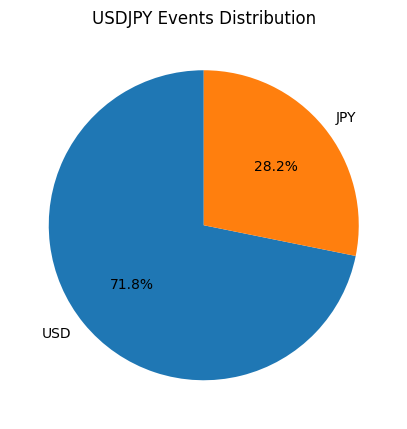

currency
USD    12374
JPY     4854
Name: count, dtype: int64

In [160]:
currency_row_count = frame['currency'].value_counts()
fig,ax = plt.subplots(figsize=(5,8))
ax.pie(currency_row_count, autopct='%1.1f%%', startangle=90,labels=currency_row_count.index)
ax.set_title(DATA + ' Events Distribution')
plt.show()
currency_row_count


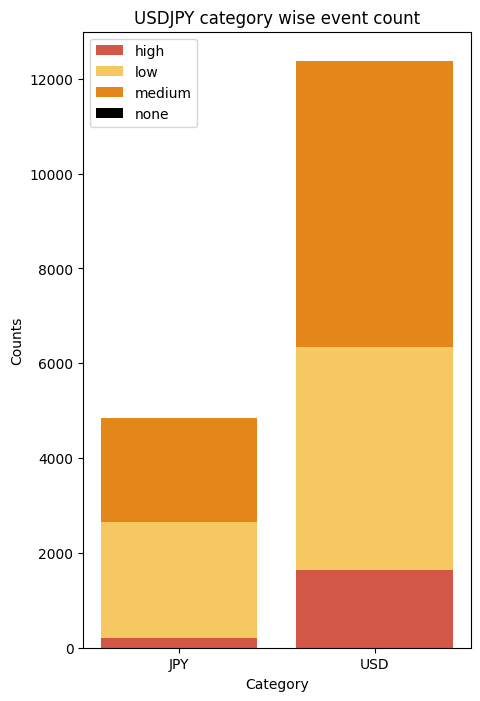

currency  impact
JPY       high       211
          low       2437
          medium    2206
USD       high      1632
          low       4717
          medium    6024
          none         1
Name: count, dtype: int64

In [161]:
currency_impact = frame[['currency','impact']].value_counts().sort_index()
currency_impact_count = frame.groupby(['currency','impact']).size().unstack(fill_value=0)
fig,ax = plt.subplots(figsize=(5,8))
bottom = None
for impact in currency_impact_count.columns:
    if bottom is None:
        p = ax.bar(currency_impact_count.index, currency_impact_count[impact], label=impact,color=IMPACT_COLORS.get(impact))
        bottom = currency_impact_count[impact]
    else:
        p = ax.bar(currency_impact_count.index, currency_impact_count[impact], bottom=bottom, label=impact,color=IMPACT_COLORS.get(impact))
        bottom += currency_impact_count[impact]
ax.set_xlabel('Category')
ax.set_ylabel('Counts')
ax.legend()
ax.set_title( DATA + ' category wise event count')
plt.show()

# currency_impact_count
currency_impact

In [162]:
frame[frame['impact']=='none'].tail()

,currency,description,impact,result,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,release_period,quarterly_period
time,,,,,,,,,,,,,,
2015-05-21 12:30:00+00:00,USD,Continuing Jobless Claims,none,green,121.088,121.226,121.152,121.054,12,5,3,21,Normal,Normal


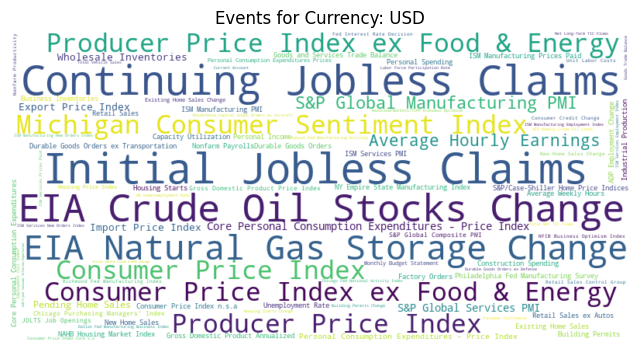

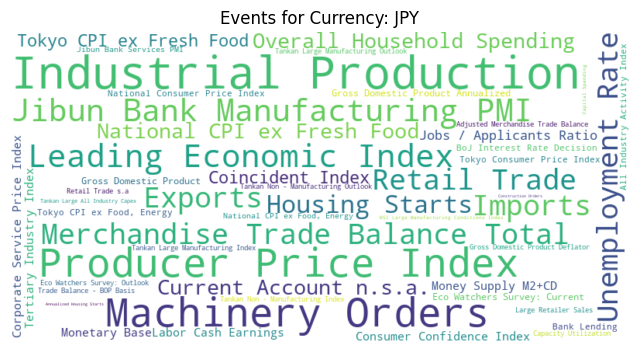

In [163]:

for currency in frame['currency'].unique():
    # Filter descriptions for the current currency
    descriptions = frame[frame['currency'] == currency]['description'].apply(process_description).value_counts()
    d = dict(zip(descriptions.index,descriptions.values))
    # # Generate word frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(d)
    # Plot the WordCloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Events for Currency: {currency}')
    plt.show()

In [164]:
pd.concat([frame['currency'],frame['description'].apply(process_description)], axis=1)[['currency','description']].value_counts().sort_values(ascending=False)

currency  description                          
USD       Initial Jobless Claims                   593
          Continuing Jobless Claims                573
          EIA Crude Oil Stocks Change              556
          EIA Natural Gas Storage Change           535
JPY       Industrial Production                    347
                                                  ... 
USD       Fed Pace of MBS Purchase Program           2
          Fed Pace of Treasury Purchase Program      2
JPY       Machine Tool Orders                        1
USD       20-Year Bond Auction                       1
          4-Week Bill Auction                        1
Name: count, Length: 148, dtype: int64

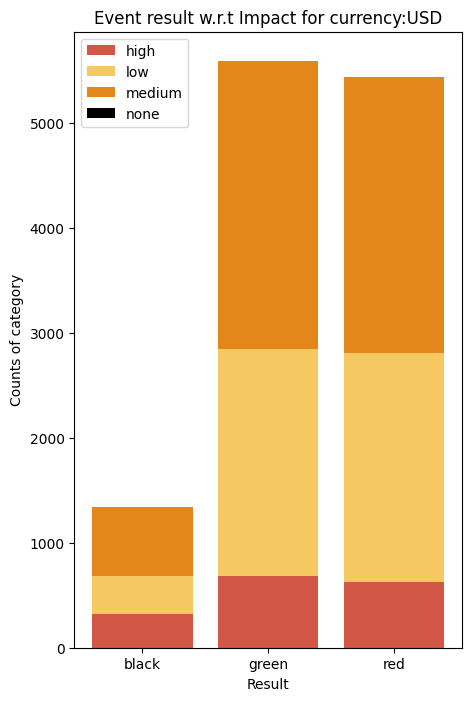

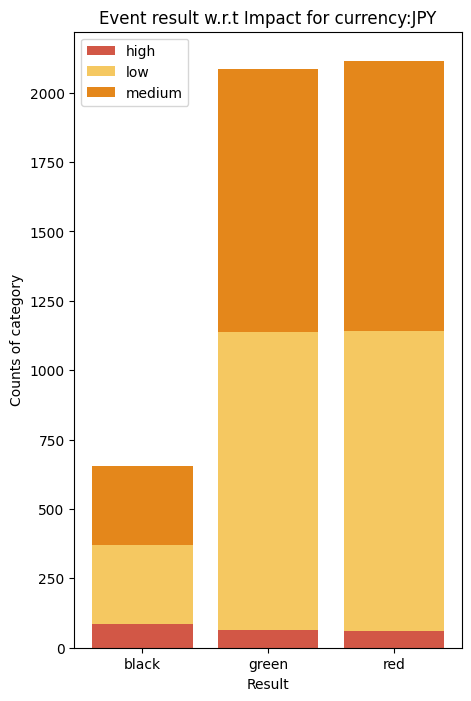

currency  impact  result
JPY       high    black       85
                  green       65
                  red         61
          low     black      286
                  green     1072
                  red       1079
          medium  black      283
                  green      949
                  red        974
USD       high    black      324
                  green      685
                  red        623
          low     black      363
                  green     2164
                  red       2190
          medium  black      659
                  green     2742
                  red       2623
          none    green        1
Name: count, dtype: int64

In [165]:
for currency in frame['currency'].unique():
    subframe = frame[frame['currency'] == currency]
    # currency_impact = subframe[['impact','result']].value_counts()
    currency_impact_count = subframe.groupby(['result','impact']).size().unstack(fill_value=0)
    fig,ax = plt.subplots(figsize=(5,8))
    bottom = None
    for impact in currency_impact_count.columns:
        if bottom is None:
            p = ax.bar(currency_impact_count.index, currency_impact_count[impact], label=impact,color=IMPACT_COLORS.get(impact))
            bottom = currency_impact_count[impact]
        else:
            p = ax.bar(currency_impact_count.index, currency_impact_count[impact], bottom=bottom, label=impact,color=IMPACT_COLORS.get(impact))
            bottom += currency_impact_count[impact]
    ax.set_xlabel('Result')
    ax.set_ylabel('Counts of category')
    ax.legend()
    ax.set_title('Event result w.r.t Impact for currency:' + currency)
    plt.show()

    currency_impact_count
    currency_impact
frame[['currency','impact','result']].value_counts().sort_index()

In [166]:
frame.columns

Index(['currency', 'description', 'impact', 'result', '0h', '1h', '3h', '5h',
       'hour_of_day', 'month_of_year', 'day_of_week', 'day_of_month',
       'release_period', 'quarterly_period'],
      dtype='object')

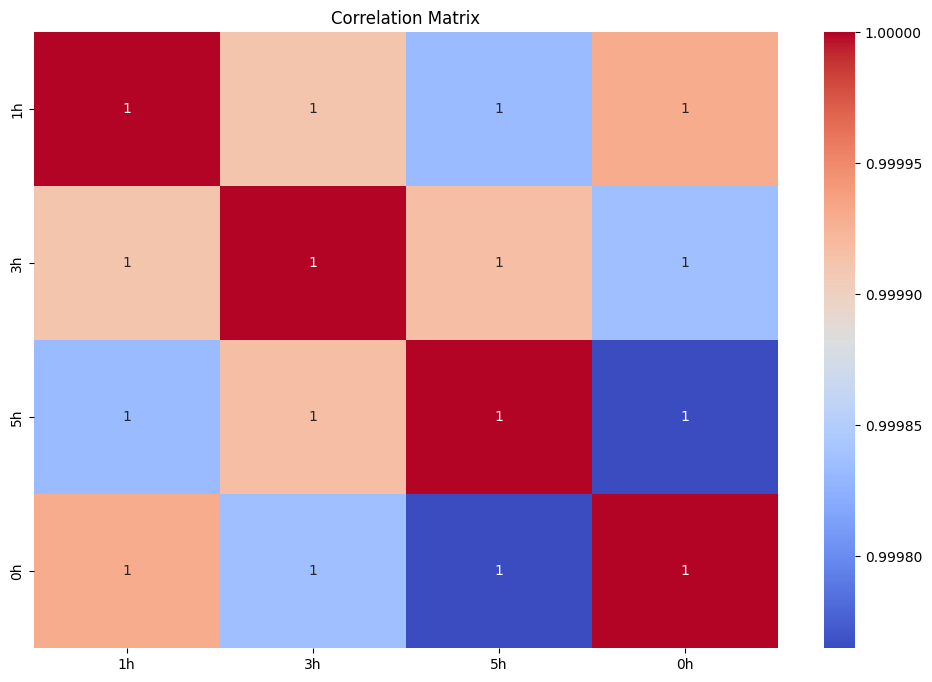

In [167]:
#Visualize the correlation matrix
prices_columns = PREDICTED_FUTURE_PRICES.copy()
prices_columns.append('0h')
plt.figure(figsize=(12, 8))
correlation_matrix = frame[prices_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



#### Encoder

In [168]:
frame.tail()

,currency,description,impact,result,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,release_period,quarterly_period
time,,,,,,,,,,,,,,
2024-06-28 12:30:00+00:00,USD,Personal Income,medium,green,160.464,160.825,160.844,160.798,12,6,4,28,MoM,Normal
2024-06-28 12:30:00+00:00,USD,Personal Spending,medium,red,160.464,160.825,160.844,160.798,12,6,4,28,Normal,Normal
2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index,medium,green,160.825,160.880,160.793,160.856,13,6,4,28,Normal,Normal
2024-06-28 14:00:00+00:00,USD,Michigan Consumer Sentiment Index,medium,green,160.880,160.844,160.798,160.836,14,6,4,28,Normal,Normal
2024-06-28 14:00:00+00:00,USD,UoM 5-year Consumer Inflation Expectation,medium,red,160.880,160.844,160.798,160.836,14,6,4,28,Normal,Normal


In [169]:
len(frame.description.unique())

142

In [170]:
EVENT_COLUMNS

['time', 'currency', 'description', 'impact', 'result']

In [171]:
# from sklearn.feature_extraction import FeatureHasher

# # Initialize FeatureHasher
# hasher = FeatureHasher(n_features=1000, input_type='string')

# # Transform the 'description' column
# # Prepare data for FeatureHasher
# hashed_descriptions = [
#     [description] for description in frame['description']
# ]
# description_hashed = hasher.transform(hashed_descriptions)

# # Convert to DataFrame (if needed)
# description_df = pd.DataFrame(description_hashed.toarray())

# # Concatenate with original DataFrame
# frame = pd.concat([frame.drop(columns=['description']), description_df], axis=1)


In [172]:
frame.reset_index(inplace=True)

In [173]:
frame

,time,currency,description,impact,result,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,release_period,quarterly_period
0,2013-01-02 14:58:00+00:00,USD,S&P Global Manufacturing PMI,low,green,87.204,87.168,87.096,87.115,14,1,2,2,Normal,Normal
1,2013-01-02 16:00:00+00:00,USD,Construction Spending,medium,red,87.092,87.096,87.115,87.337,16,1,2,2,MoM,Normal
2,2013-01-02 16:00:00+00:00,USD,ISM Manufacturing PMI,high,red,87.092,87.096,87.115,87.337,16,1,2,2,Normal,Normal
3,2013-01-02 16:00:00+00:00,USD,ISM Manufacturing Prices Paid,medium,green,87.092,87.096,87.115,87.337,16,1,2,2,Normal,Normal
4,2013-01-03 14:15:00+00:00,USD,ADP Employment Change,medium,green,86.958,86.831,86.868,87.160,14,1,3,3,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17223,2024-06-28 12:30:00+00:00,USD,Personal Income,medium,green,160.464,160.825,160.844,160.798,12,6,4,28,MoM,Normal
17224,2024-06-28 12:30:00+00:00,USD,Personal Spending,medium,red,160.464,160.825,160.844,160.798,12,6,4,28,Normal,Normal
17225,2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index,medium,green,160.825,160.880,160.793,160.856,13,6,4,28,Normal,Normal
17226,2024-06-28 14:00:00+00:00,USD,Michigan Consumer Sentiment Index,medium,green,160.880,160.844,160.798,160.836,14,6,4,28,Normal,Normal


In [174]:
labelencoder = LabelEncoder()
frame['description'] = labelencoder.fit_transform(frame['description'])

# Apply OneHotEncoder to categorical columns
categorical_columns = ['currency', 'impact', 'result','release_period','quarterly_period']
# categorical_columns = ['currency', 'impact', 'result','release_period','quarterly_period','description']
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_data = encoder.fit_transform(frame[categorical_columns])

# Create DataFrame for the encoded columns
encoded_columns = encoder.get_feature_names_out(categorical_columns)
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoded_columns)

# Drop the original categorical columns and concatenate the encoded columns
frame = frame.drop(columns=categorical_columns).reset_index(drop=True)
frame = pd.concat([frame, encoded_categorical_df], axis=1)

print(frame.head())

                       time  description      0h      1h      3h      5h  \
0 2013-01-02 14:58:00+00:00          122  87.204  87.168  87.096  87.115   
1 2013-01-02 16:00:00+00:00           21  87.092  87.096  87.115  87.337   
2 2013-01-02 16:00:00+00:00           63  87.092  87.096  87.115  87.337   
3 2013-01-02 16:00:00+00:00           64  87.092  87.096  87.115  87.337   
4 2013-01-03 14:15:00+00:00            2  86.958  86.831  86.868  87.160   

   hour_of_day  month_of_year  day_of_week  day_of_month  ...  result_red  \
0           14              1            2             2  ...         0.0   
1           16              1            2             2  ...         1.0   
2           16              1            2             2  ...         1.0   
3           16              1            2             2  ...         0.0   
4           14              1            3             3  ...         0.0   

   release_period_MoM  release_period_Normal  release_period_QoQ  \
0           

In [175]:
frame.head()
frame.set_index(pd.to_datetime(frame['time']),inplace=True)
frame.drop(columns=['time'],inplace=True)

In [176]:
frame

,description,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,currency_JPY,...,result_red,release_period_MoM,release_period_Normal,release_period_QoQ,release_period_YoY,quarterly_period_Normal,quarterly_period_Q1,quarterly_period_Q2,quarterly_period_Q3,quarterly_period_Q4
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 14:58:00+00:00,122,87.204,87.168,87.096,87.115,14,1,2,2,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,21,87.092,87.096,87.115,87.337,16,1,2,2,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,63,87.092,87.096,87.115,87.337,16,1,2,2,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,64,87.092,87.096,87.115,87.337,16,1,2,2,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03 14:15:00+00:00,2,86.958,86.831,86.868,87.160,14,1,3,3,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28 12:30:00+00:00,109,160.464,160.825,160.844,160.798,12,6,4,28,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-28 12:30:00+00:00,110,160.464,160.825,160.844,160.798,12,6,4,28,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-28 13:45:00+00:00,18,160.825,160.880,160.793,160.856,13,6,4,28,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [177]:
frame

,description,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,currency_JPY,...,result_red,release_period_MoM,release_period_Normal,release_period_QoQ,release_period_YoY,quarterly_period_Normal,quarterly_period_Q1,quarterly_period_Q2,quarterly_period_Q3,quarterly_period_Q4
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 14:58:00+00:00,122,87.204,87.168,87.096,87.115,14,1,2,2,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,21,87.092,87.096,87.115,87.337,16,1,2,2,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,63,87.092,87.096,87.115,87.337,16,1,2,2,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,64,87.092,87.096,87.115,87.337,16,1,2,2,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03 14:15:00+00:00,2,86.958,86.831,86.868,87.160,14,1,3,3,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28 12:30:00+00:00,109,160.464,160.825,160.844,160.798,12,6,4,28,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-28 12:30:00+00:00,110,160.464,160.825,160.844,160.798,12,6,4,28,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-28 13:45:00+00:00,18,160.825,160.880,160.793,160.856,13,6,4,28,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Encoding the columns

In [178]:
columns = frame.columns.values.tolist()
for item in PREDICTED_FUTURE_PRICES:
    columns.remove(item)
columns

['description',
 '0h',
 'hour_of_day',
 'month_of_year',
 'day_of_week',
 'day_of_month',
 'currency_JPY',
 'currency_USD',
 'impact_high',
 'impact_low',
 'impact_medium',
 'impact_none',
 'result_black',
 'result_green',
 'result_red',
 'release_period_MoM',
 'release_period_Normal',
 'release_period_QoQ',
 'release_period_YoY',
 'quarterly_period_Normal',
 'quarterly_period_Q1',
 'quarterly_period_Q2',
 'quarterly_period_Q3',
 'quarterly_period_Q4']

In [179]:
frame[columns]

,description,0h,hour_of_day,month_of_year,day_of_week,day_of_month,currency_JPY,currency_USD,impact_high,impact_low,...,result_red,release_period_MoM,release_period_Normal,release_period_QoQ,release_period_YoY,quarterly_period_Normal,quarterly_period_Q1,quarterly_period_Q2,quarterly_period_Q3,quarterly_period_Q4
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 14:58:00+00:00,122,87.204,14,1,2,2,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,21,87.092,16,1,2,2,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,63,87.092,16,1,2,2,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,64,87.092,16,1,2,2,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03 14:15:00+00:00,2,86.958,14,1,3,3,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28 12:30:00+00:00,109,160.464,12,6,4,28,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-28 12:30:00+00:00,110,160.464,12,6,4,28,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-28 13:45:00+00:00,18,160.825,13,6,4,28,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [180]:
frame.head()

,description,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,currency_JPY,...,result_red,release_period_MoM,release_period_Normal,release_period_QoQ,release_period_YoY,quarterly_period_Normal,quarterly_period_Q1,quarterly_period_Q2,quarterly_period_Q3,quarterly_period_Q4
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 14:58:00+00:00,122,87.204,87.168,87.096,87.115,14,1,2,2,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,21,87.092,87.096,87.115,87.337,16,1,2,2,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,63,87.092,87.096,87.115,87.337,16,1,2,2,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,64,87.092,87.096,87.115,87.337,16,1,2,2,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03 14:15:00+00:00,2,86.958,86.831,86.868,87.160,14,1,3,3,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [181]:
from sklearn.model_selection import TimeSeriesSplit

frame.sort_index(inplace=True)
features = frame[columns] # Add more features as needed
target_1h = frame['1h']
target_3h = frame['3h']
target_5h = frame['5h']
# # Split data into training and testing sets
# X_train, X_test, y_train_1h, y_test_1h = train_test_split(features, target_1h, test_size=0.2, random_state=42)
# _, _, y_train_3h, y_test_3h = train_test_split(features, target_3h, test_size=0.2, random_state=42)
# _, _, y_train_5h, y_test_5h = train_test_split(features, target_5h, test_size=0.2, random_state=42)



# train, test = frame[:train_size], frame[train_size:]


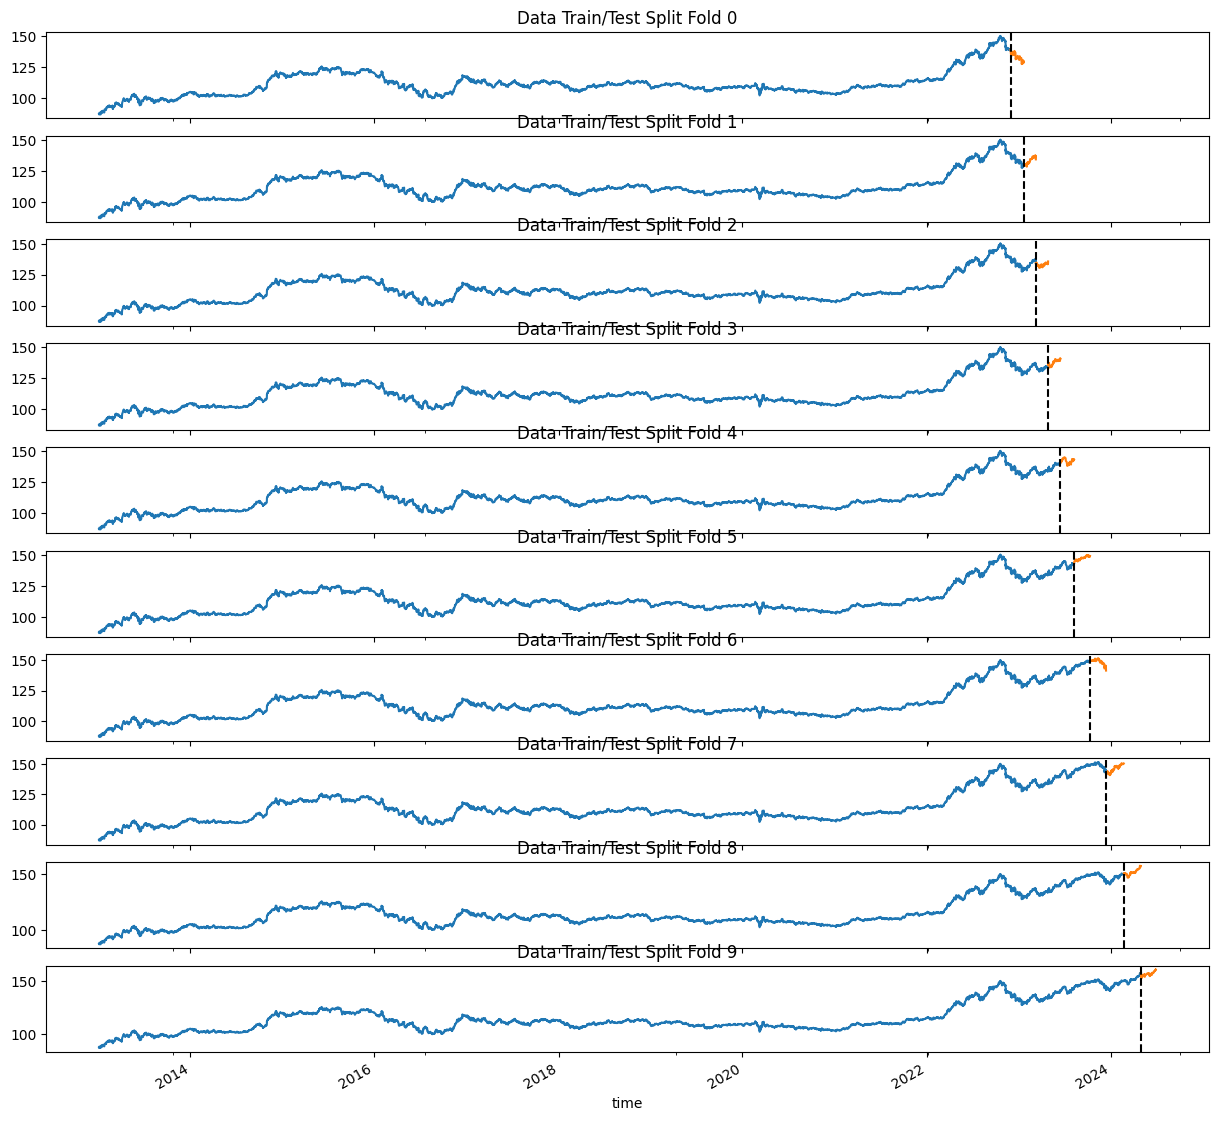

In [182]:
folds= 10
tss = TimeSeriesSplit(n_splits=folds,test_size=250)



fig, axs = plt.subplots(folds, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx , val_idx in tss.split(frame):
    train = frame.iloc[train_idx]
    test = frame.iloc[val_idx]
    train['1h'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['1h'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [183]:
from sklearn.linear_model import LinearRegression

# train_size = int(len(frame.index.normalize().unique()) * 0.99)

# # Define the start and end dates for the training period
# window_size_days = train_size  # Number of days in each training set
# step_size_days = 1    # Number of days to move the window

# # Get unique days
# unique_days = frame.index.normalize().unique()
# print(len(unique_days))
# for i in range(window_size_days, len(unique_days)):
#     # Training period
#     train_start_day = unique_days[0]
#     train_end_day = unique_days[i] - pd.Timedelta(seconds=1)
#     # print(train_start_day)
#     # print(train_end_day)
#     # Test period
#     test_start_day = unique_days[i]
#     test_end_day = unique_days[i] + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

#     print(train_start_day)
#     print(train_end_day)
#     print(test_start_day)
#     print(test_end_day)
#     print()
#     # Slice the DataFrame using date ranges
#     X_train = features[train_start_day:train_end_day]
#     X_test = features[test_start_day:test_end_day]
#     y_train_1h, y_test_1h = target_1h[train_start_day:train_end_day], target_1h[test_start_day:test_end_day]
#     y_train_3h, y_test_3h = target_3h[train_start_day:train_end_day], target_3h[test_start_day:test_end_day]
#     y_train_5h, y_test_5h = target_5h[train_start_day:train_end_day], target_5h[test_start_day:test_end_day]


#     model_1h = LinearRegression()
#     model_3h = LinearRegression()
#     model_5h = LinearRegression()

#     model_1h.fit(X_train, y_train_1h)
#     model_3h.fit(X_train, y_train_3h)
#     model_5h.fit(X_train, y_train_5h)

#     # Predict and evaluate
#     y_pred_1h = model_1h.predict(X_test)
#     y_pred_3h = model_3h.predict(X_test)
#     y_pred_5h = model_5h.predict(X_test)

#     # print("Intercept:",model_1h.intercept_ ,"\nCoefficients:",model_1h.coef_)
#     # print("Intercept:",model_3h.intercept_ ,"\nCoefficients:",model_3h.coef_)
#     # print("Intercept:",model_5h.intercept_ ,"\nCoefficients:",model_5h.coef_)
#     print_metrics(y_test_1h,y_pred_1h,'1h')
#     print_metrics(y_test_3h,y_pred_3h,'3h')
#     print_metrics(y_test_5h,y_pred_5h,'5h')

In [184]:
# from sklearn.ensemble import RandomForestRegressor
# # Rolling forecast origin parameters
# initial_training_days = train_size  # Initial number of days in the training set
# test_window_days = 1       # Number of days in the test set

# # Get unique days
# unique_days = frame.index.normalize().unique()

# # Initialize lists to store the train and test indices
# train_indices = []
# test_indices = []

# # Create rolling forecast origin windows
# for i in range(initial_training_days, len(unique_days)):
#     # Training period
#     train_start_day = unique_days[0]
#     train_end_day = unique_days[i] - pd.Timedelta(seconds=1)
    
#     # Test period
#     test_start_day = unique_days[i]
#     test_end_day = unique_days[i] + pd.Timedelta(days=test_window_days) - pd.Timedelta(seconds=1)
    
#     # Slice the DataFrame using date ranges
#     train = frame[train_start_day:train_end_day]
#     test = frame[test_start_day:test_end_day ]
    
#     print(train_start_day)
#     print(train_end_day)
#     print(test_start_day)
#     print(test_end_day)
#     print()

#     # Train a Random Forest model for each target
#     model_1h = RandomForestRegressor(random_state=42)
#     model_3h = RandomForestRegressor(random_state=42)
#     model_5h = RandomForestRegressor(random_state=42)

#     model_1h.fit(X_train, y_train_1h)
#     model_3h.fit(X_train, y_train_3h)
#     model_5h.fit(X_train, y_train_5h)

#     # Predict and evaluate
#     y_pred_1h = model_1h.predict(X_test)
#     y_pred_3h = model_3h.predict(X_test)
#     y_pred_5h = model_5h.predict(X_test)

#     print_metrics(y_test_1h,y_pred_1h,'1h')
#     print_metrics(y_test_3h,y_pred_3h,'3h')
#     print_metrics(y_test_5h,y_pred_5h,'5h')
   
    


In [185]:
import itertools as it
TRAIN_TEST_LABEL = ['train','test']


In [186]:
# Calculate accuracy metrics

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2_scores = {}
mse_scores = {}
mae_scores = {}
rmse_scores ={}

def reset_evaluation_matrics():
    global r2_scores, mse_scores, mae_scores, rmse_scores
    r2_scores = {}
    mse_scores = {}
    mae_scores = {}
    rmse_scores ={}
    for item in it.product(PREDICTED_FUTURE_PRICES,TRAIN_TEST_LABEL):
        item = '_'.join(item)
        r2_scores[item] , mse_scores[item] , mae_scores[item] , rmse_scores[item] = [] , [], [], []
    # print_vars()

def print_metrics(y_true, y_pred, label):
    global r2_scores, mse_scores, mae_scores, rmse_scores
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2_scores[label].append(r2)
    mse_scores[label].append(mse)
    mae_scores[label].append(mae)
    rmse_scores[label].append(rmse)
    print(f'{label} - R^2: {r2:.4f}')
    print(f'{label} - Mean Absolute Error (MAE): {mae:.4f}')
    print(f'{label} - Mean Squared Error (MSE): {mse:.4f}')
    print(f'{label} - Root Mean Squared Error (RMSE): {rmse:.4f}')
    print('-------------------------------------------')
    # print_vars()
    print('------------------------------------------')

    return (r2,mae,mse,rmse)


def print_vars():
    global r2_scores, mse_scores, mae_scores, rmse_scores
    print(r2_scores)
    print(mse_scores)
    print(mae_scores)
    print(rmse_scores)

In [187]:
from statistics import mean
def model_training(model_function):
    reset_evaluation_matrics()
    print_vars()
    for train_index, test_index in tss.split(frame):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train_1h, y_test_1h = target_1h.iloc[train_index], target_1h.iloc[test_index]
        y_train_3h, y_test_3h = target_3h.iloc[train_index], target_3h.iloc[test_index]
        y_train_5h, y_test_5h = target_5h.iloc[train_index], target_5h.iloc[test_index]
        model_function(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h)

    for label in it.product(PREDICTED_FUTURE_PRICES,TRAIN_TEST_LABEL):
        label = '_'.join(label)
        print(f'Final Scores for {label} prices')
        print(f'{label} - R^2: {mean(r2_scores[label]):.4f}')
        print(f'{label} - Mean Absolute Error (MAE): {mean(mae_scores[label]):.4f}')
        print(f'{label} - Mean Squared Error (MSE): {mean(mse_scores[label]):.4f}')
        print(f'{label} - Root Mean Squared Error (RMSE): {mean(rmse_scores[label]):.4f}')
        print('-----------------------------------------------------------------------------------------------------')
 

In [188]:
def linear_regression_model(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    model_1h = LinearRegression()
    model_3h = LinearRegression()
    model_5h = LinearRegression()

    model_1h.fit(X_train, y_train_1h)
    model_3h.fit(X_train, y_train_3h)
    model_5h.fit(X_train, y_train_5h)

    # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')

In [189]:
model_training(linear_regression_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
1h_train - R^2: 0.9997
1h_train - Mean Absolute Error (MAE): 0.1055
1h_train - Mean Squared Error (MSE): 0.0261
1h_train - Root Mean Squared Error (RMSE): 0.1616
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9993
3h_train - Mean Absolute Error (MAE): 0.1689
3h_train - Mean Squared Error (MSE): 0.0622
3h_train - Root Mean Squared Error (RMSE): 0.2494
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9991
5h_train - Mean Absolute Error (MAE): 0.1989
5h_train - Mean Squared Error (MSE): 0.0874
5h_train - Roo

In [190]:
from sklearn.tree import DecisionTreeRegressor

def decision_tree_reg_model(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    # Train a Decision Tree model for each target
    model_1h = DecisionTreeRegressor(random_state=42)
    model_3h = DecisionTreeRegressor(random_state=42)
    model_5h = DecisionTreeRegressor(random_state=42)

    model_1h.fit(X_train, y_train_1h)
    model_3h.fit(X_train, y_train_3h)
    model_5h.fit(X_train, y_train_5h)

    # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')


In [191]:
model_training(decision_tree_reg_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
1h_train - R^2: 1.0000
1h_train - Mean Absolute Error (MAE): 0.0000
1h_train - Mean Squared Error (MSE): 0.0000
1h_train - Root Mean Squared Error (RMSE): 0.0000
-------------------------------------------
------------------------------------------
3h_train - R^2: 1.0000
3h_train - Mean Absolute Error (MAE): 0.0000
3h_train - Mean Squared Error (MSE): 0.0000
3h_train - Root Mean Squared Error (RMSE): 0.0000
-------------------------------------------
------------------------------------------
5h_train - R^2: 1.0000
5h_train - Mean Absolute Error (MAE): 0.0000
5h_train - Mean Squared Error (MSE): 0.0000
5h_train - Roo

In [192]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model for each target
def random_forest_regressor_model(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    model_1h = RandomForestRegressor(random_state=42)
    model_3h = RandomForestRegressor(random_state=42)
    model_5h = RandomForestRegressor(random_state=42)

    model_1h.fit(X_train, y_train_1h)
    model_3h.fit(X_train, y_train_3h)
    model_5h.fit(X_train, y_train_5h)

    # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')


In [193]:
model_training(random_forest_regressor_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
1h_train - R^2: 1.0000
1h_train - Mean Absolute Error (MAE): 0.0184
1h_train - Mean Squared Error (MSE): 0.0011
1h_train - Root Mean Squared Error (RMSE): 0.0335
-------------------------------------------
------------------------------------------
3h_train - R^2: 1.0000
3h_train - Mean Absolute Error (MAE): 0.0277
3h_train - Mean Squared Error (MSE): 0.0026
3h_train - Root Mean Squared Error (RMSE): 0.0514
-------------------------------------------
------------------------------------------
5h_train - R^2: 1.0000
5h_train - Mean Absolute Error (MAE): 0.0328
5h_train - Mean Squared Error (MSE): 0.0039
5h_train - Roo

In [194]:
import xgboost as xgb
def xgb_regressor_model(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    # Train an XGBoost model for each target
    model_1h = xgb.XGBRegressor(random_state=42)
    model_3h = xgb.XGBRegressor(random_state=42)
    model_5h = xgb.XGBRegressor(random_state=42)

    model_1h.fit(X_train, y_train_1h)
    model_3h.fit(X_train, y_train_3h)
    model_5h.fit(X_train, y_train_5h)

    # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')


In [195]:
model_training(xgb_regressor_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
1h_train - R^2: 0.9999
1h_train - Mean Absolute Error (MAE): 0.0741
1h_train - Mean Squared Error (MSE): 0.0105
1h_train - Root Mean Squared Error (RMSE): 0.1026
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9998
3h_train - Mean Absolute Error (MAE): 0.1036
3h_train - Mean Squared Error (MSE): 0.0213
3h_train - Root Mean Squared Error (RMSE): 0.1459
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9997
5h_train - Mean Absolute Error (MAE): 0.1179
5h_train - Mean Squared Error (MSE): 0.0281
5h_train - Roo

In [196]:
from sklearn.svm import SVR

def support_vector_regressor_model(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    # Train an SVR model for each target
    model_1h = SVR()
    model_3h = SVR()
    model_5h = SVR()

    model_1h.fit(X_train, y_train_1h)
    model_3h.fit(X_train, y_train_3h)
    model_5h.fit(X_train, y_train_5h)

    # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')


In [197]:
# model_training(support_vector_regressor_model)

In [198]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


def create_model(X_train_scaled):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def neural_network_model(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define a simple feedforward neural network

    # Train a neural network model for each target
    model_1h = create_model(X_train)
    model_3h = create_model(X_train)
    model_5h = create_model(X_train)

    model_1h.fit(X_train, y_train_1h, epochs=20, batch_size=32, verbose=0)
    model_3h.fit(X_train, y_train_3h, epochs=20, batch_size=32, verbose=0)
    model_5h.fit(X_train, y_train_5h, epochs=20, batch_size=32, verbose=0)

    # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')


In [199]:
model_training(neural_network_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}


e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step
1h_train - R^2: 0.9971
1h_train - Mean Absolute Error (MAE): 0.3884
1h_train - Mean Squared Error (MSE): 0.2774
1h_train - Root Mean Squared Error (RMSE): 0.5267
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9971
3h_train - Mean Absolute Error (MAE): 0.3694
3h_train - Mean Squared Error (MSE): 0.2785
3h_train - Root Mean Squared Error (RMSE): 0.5278
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9969
5h_train - Mean Absolute Error (MAE): 0.3696
5h_train - Mean Squared Error (MSE): 0.2938
5h_train - Root Mean Squared Error (RMSE): 0.5421
-------------------------------------------
------------------------------------------
1h_test 

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1h_train - R^2: 0.9973
1h_train - Mean Absolute Error (MAE): 0.3387
1h_train - Mean Squared Error (MSE): 0.2755
1h_train - Root Mean Squared Error (RMSE): 0.5249
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9955
3h_train - Mean Absolute Error (MAE): 0.4261
3h_train - Mean Squared Error (MSE): 0.4545
3h_train - Root Mean Squared Error (RMSE): 0.6741
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9948
5h_train - Mean Absolute Error (MAE): 0.5201
5h_train - Mean Squared Error (MSE): 0.5314
5h_train - Root Mean Squared Error (RMSE): 0.7289
-------------------------------------------
------------------------------------------
1h_test - 

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1h_train - R^2: 0.9978
1h_train - Mean Absolute Error (MAE): 0.3609
1h_train - Mean Squared Error (MSE): 0.2412
1h_train - Root Mean Squared Error (RMSE): 0.4911
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9977
3h_train - Mean Absolute Error (MAE): 0.3489
3h_train - Mean Squared Error (MSE): 0.2433
3h_train - Root Mean Squared Error (RMSE): 0.4933
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9971
5h_train - Mean Absolute Error (MAE): 0.3909
5h_train - Mean Squared Error (MSE): 0.3136
5h_train - Root Mean Squared Error (RMSE): 0.5600
-------------------------------------------
------------------------------------------
1h_test - 

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1h_train - R^2: 0.9979
1h_train - Mean Absolute Error (MAE): 0.3395
1h_train - Mean Squared Error (MSE): 0.2385
1h_train - Root Mean Squared Error (RMSE): 0.4883
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9975
3h_train - Mean Absolute Error (MAE): 0.4080
3h_train - Mean Squared Error (MSE): 0.2842
3h_train - Root Mean Squared Error (RMSE): 0.5331
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9968
5h_train - Mean Absolute Error (MAE): 0.4466
5h_train - Mean Squared Error (MSE): 0.3578
5h_train - Root Mean Squared Error (RMSE): 0.5981
-------------------------------------------
------------------------------------------
1h_test - 

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1h_train - R^2: 0.9899
1h_train - Mean Absolute Error (MAE): 0.4312
1h_train - Mean Squared Error (MSE): 1.2293
1h_train - Root Mean Squared Error (RMSE): 1.1087
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9982
3h_train - Mean Absolute Error (MAE): 0.3406
3h_train - Mean Squared Error (MSE): 0.2186
3h_train - Root Mean Squared Error (RMSE): 0.4675
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9974
5h_train - Mean Absolute Error (MAE): 0.4304
5h_train - Mean Squared Error (MSE): 0.3209
5h_train - Root Mean Squared Error (RMSE): 0.5665
-------------------------------------------
------------------------------------------
1h_test 

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1h_train - R^2: 0.9985
1h_train - Mean Absolute Error (MAE): 0.3065
1h_train - Mean Squared Error (MSE): 0.2013
1h_train - Root Mean Squared Error (RMSE): 0.4487
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9911
3h_train - Mean Absolute Error (MAE): 0.4211
3h_train - Mean Squared Error (MSE): 1.1860
3h_train - Root Mean Squared Error (RMSE): 1.0890
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9978
5h_train - Mean Absolute Error (MAE): 0.3978
5h_train - Mean Squared Error (MSE): 0.2972
5h_train - Root Mean Squared Error (RMSE): 0.5452
-------------------------------------------
------------------------------------------
1h_test -

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 104us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
1h_train - R^2: 0.9980
1h_train - Mean Absolute Error (MAE): 0.4122
1h_train - Mean Squared Error (MSE): 0.2997
1h_train - Root Mean Squared Error (RMSE): 0.5475
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9982
3h_train - Mean Absolute Error (MAE): 0.3586
3h_train - Mean Squared Error (MSE): 0.2661
3h_train - Root Mean Squared Error (RMSE): 0.5159
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9978
5h_train - Mean Absolute Error (MAE): 0.4302
5h_train - Mean Squared Error (MSE): 0.3192
5h_train - Root Mean Squared Error (RMSE): 0.5650
-------------------------------------------
------------------------------------------
1h_test 

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1h_train - R^2: 0.9987
1h_train - Mean Absolute Error (MAE): 0.3335
1h_train - Mean Squared Error (MSE): 0.2080
1h_train - Root Mean Squared Error (RMSE): 0.4560
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9983
3h_train - Mean Absolute Error (MAE): 0.3649
3h_train - Mean Squared Error (MSE): 0.2735
3h_train - Root Mean Squared Error (RMSE): 0.5230
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9927
5h_train - Mean Absolute Error (MAE): 0.4455
5h_train - Mean Squared Error (MSE): 1.2025
5h_train - Root Mean Squared Error (RMSE): 1.0966
-------------------------------------------
------------------------------------------
1h_test -

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1h_train - R^2: 0.9987
1h_train - Mean Absolute Error (MAE): 0.3280
1h_train - Mean Squared Error (MSE): 0.2304
1h_train - Root Mean Squared Error (RMSE): 0.4800
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9972
3h_train - Mean Absolute Error (MAE): 0.3979
3h_train - Mean Squared Error (MSE): 0.4904
3h_train - Root Mean Squared Error (RMSE): 0.7003
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9981
5h_train - Mean Absolute Error (MAE): 0.4249
5h_train - Mean Squared Error (MSE): 0.3332
5h_train - Root Mean Squared Error (RMSE): 0.5772
-------------------------------------------
------------------------------------------
1h_test - R

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step
531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1h_train - R^2: 0.9989
1h_train - Mean Absolute Error (MAE): 0.3040
1h_train - Mean Squared Error (MSE): 0.2119
1h_train - Root Mean Squared Error (RMSE): 0.4603
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9985
3h_train - Mean Absolute Error (MAE): 0.3927
3h_train - Mean Squared Error (MSE): 0.2831
3h_train - Root Mean Squared Error (RMSE): 0.5321
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9982
5h_train - Mean Absolute Error (MAE): 0.4516
5h_train - Mean Squared Error (MSE): 0.3584
5h_train - Root Mean Squared Error (RMSE): 0.5987
-------------------------------------------
------------------------------------------
1h_test -

In [200]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# Defining the RNN model
def build_rnn_model(X_train_rnn):
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def recurrenct_neural_network_model(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    # Scaling the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshaping data for RNN (samples, timesteps, features)
    X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test= X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Training the model for each target
    model_1h = build_rnn_model(X_train)
    model_3h = build_rnn_model(X_train)
    model_5h = build_rnn_model(X_train)
    
    
    model_1h.fit(X_train, y_train_1h, epochs=20, verbose=1)
    model_3h.fit(X_train, y_train_3h, epochs=20, verbose=1)
    model_5h.fit(X_train, y_train_5h, epochs=20, verbose=1)

     # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')


In [201]:
model_training(recurrenct_neural_network_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
Epoch 1/20


e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 999us/step - loss: 11778.7930
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 5348.1689
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 579.2146
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 117.6866
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 71.5878
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 46.0174
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 29.3280
Epoch 8/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 20.0071
Epoch 9/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 13.7799
Epoch 10/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 10.0722
Epoch 11/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.6090
Epoch 12/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5960
Epoch 13/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 4.3775
Epoch 14/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.4593
Epoch 15/20
461/461 ━━━━━━━━━━━

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - loss: 11628.0752
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - loss: 3947.0933
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 233.2533
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 88.8159
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 53.5054
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 31.1094
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 20.8766
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 15.3466
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 11.2852
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 8.8859
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 6.6573
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 5.1831
Epoch 13/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 3.9241
Epoch 14/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 3.0727
Epoch 15/20
469/469 ━━━━━

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


476/476 ━━━━━━━━━━━━━━━━━━━━ 2s 981us/step - loss: 11682.6162
Epoch 2/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 4037.2913
Epoch 3/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 250.8676
Epoch 4/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 91.8766
Epoch 5/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 55.2394
Epoch 6/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 33.7245
Epoch 7/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 20.7801
Epoch 8/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 14.6948
Epoch 9/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 10.3966
Epoch 10/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 7.7342
Epoch 11/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 6.2535
Epoch 12/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 4.7421
Epoch 13/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 3.7805
Epoch 14/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 2.9440
Epoch 15/20
476/476 ━━━━━

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 11481.9766
Epoch 2/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 3327.6326
Epoch 3/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 255.3253
Epoch 4/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 102.8110
Epoch 5/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 53.5416
Epoch 6/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 29.1580
Epoch 7/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 17.2608
Epoch 8/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 11.7933
Epoch 9/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.7429
Epoch 10/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 6.7999
Epoch 11/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 5.5105
Epoch 12/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 4.3772
Epoch 13/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 3.4497
Epoch 14/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 2.6360
Epoch 15/20
484/484 ━━━━━━━━━━━

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 985us/step - loss: 11705.8213
Epoch 2/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 3490.6167
Epoch 3/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 173.2914
Epoch 4/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 77.3206
Epoch 5/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 45.3994
Epoch 6/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 26.3938
Epoch 7/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 17.6779
Epoch 8/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 12.3268
Epoch 9/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 9.3721
Epoch 10/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - loss: 7.0705
Epoch 11/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 5.4826
Epoch 12/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 4.0693
Epoch 13/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 3.3116
Epoch 14/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.5268
Epoch 15/20
492/492 ━━━━━━━━

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 936us/step - loss: 11801.3877
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 3454.9148
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 183.3871
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 72.9386
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 43.5614
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 28.0255
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 19.2425
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 13.7789
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 10.3381
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step - loss: 7.8234
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 5.7473
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 4.2956
Epoch 13/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.1287
Epoch 14/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3801
Epoch 15/20
500/500 ━━━━━━━━━

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step - loss: 11698.0811
Epoch 2/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 2890.2654
Epoch 3/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 127.0161
Epoch 4/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 61.8772
Epoch 5/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 37.6443
Epoch 6/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 24.1925
Epoch 7/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 16.7009
Epoch 8/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 11.7261
Epoch 9/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 8.7760
Epoch 10/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 6.2571
Epoch 11/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 4.8651
Epoch 12/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - loss: 3.8294
Epoch 13/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 2.8309
Epoch 14/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 2.2395
Epoch 15/20
508/508 ━━━━━━

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 928us/step - loss: 11799.5801
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - loss: 3213.7605
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 165.4131
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 79.0104
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 45.9050
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 27.7327
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 18.4703
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 13.0383
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 9.9798 
Epoch 10/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 7.4847
Epoch 11/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - loss: 5.9714
Epoch 12/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 4.6383
Epoch 13/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 3.4497
Epoch 14/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 2.6051
Epoch 15/20
515/515 ━━━━━

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step - loss: 11934.9580
Epoch 2/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 2896.1047
Epoch 3/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 172.6149
Epoch 4/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 82.4471
Epoch 5/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 42.2049
Epoch 6/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 22.6743
Epoch 7/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - loss: 14.7939
Epoch 8/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 10.6691
Epoch 9/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 7.8062
Epoch 10/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 6.3661
Epoch 11/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 5.1313
Epoch 12/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 4.1928
Epoch 13/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 3.3666
Epoch 14/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 2.7121
Epoch 15/20
523/523 ━━━━━━

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 2s 823us/step - loss: 12292.5889
Epoch 2/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 3282.5530
Epoch 3/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - loss: 169.8035
Epoch 4/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 88.0593
Epoch 5/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 50.0367
Epoch 6/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 32.0454
Epoch 7/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step - loss: 22.1877
Epoch 8/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 15.9035
Epoch 9/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 11.9679
Epoch 10/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 8.7562
Epoch 11/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - loss: 6.6562
Epoch 12/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 4.9169
Epoch 13/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 3.6178
Epoch 14/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 2.8430
Epoch 15/20
531/531 ━━━━━

In [202]:
!pip install keras-tcn



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [203]:
from tensorflow.keras.layers import Input, Conv1D, Dense, Lambda, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Defining the TCN model
def build_tcn_model(input_shape):
    i = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(i)
    x = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(x)
    x = Flatten()(x)
    o = Dense(1)(x)
    model = Model(inputs=[i], outputs=[o])
    model.compile(optimizer='adam', loss='mse')
    return model

def temporal_neural_network(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Reshaping data for TCN (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Training the model for each target
    model_1h = build_tcn_model((X_train.shape[1], 1))
    model_3h = build_tcn_model((X_train.shape[1], 1))
    model_5h = build_tcn_model((X_train.shape[1], 1))


    model_1h.fit(X_train, y_train_1h, epochs=20, verbose=1)
    model_3h.fit(X_train, y_train_3h, epochs=20, verbose=1)
    model_5h.fit(X_train, y_train_5h, epochs=20, verbose=1)

    # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')


In [204]:
model_training(temporal_neural_network)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
Epoch 1/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3712.2610
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 18.6935
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 57.3939
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 11.5447
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8317
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1315
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3100
Epoch 8/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6204
Epoch 9/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5191
Epoch 10/20
461